## **Criação dos Modelos de Aprendizado de Máquina - Risco de Inadimplência de Crédito Residencial**

## Importando bibliotecas - SETUP

In [1]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import botocore 
import sagemaker
import numpy as np
import pandas as pd 
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sagemaker import get_execution_role 
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

## Lendo o conjunto de dados processados

In [2]:
bucket='credit2022processados'

In [3]:
prefix = 'EDA/a_train'

In [4]:
role = get_execution_role() 

data_key_train = 'a_train.csv' 
data_location_train = 's3://{}/{}/{}'.format(bucket, prefix, data_key_train) 

a_train = pd.read_csv(data_location_train) 
a_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,0,1,406597.5,351000.0,0.018801,9461,-637,-3648.0,...,0,0,1,0,1,0,0,1,0,1
1,100003,0,0,0,1293502.5,1129500.0,0.003541,16765,-1188,-1186.0,...,0,0,1,0,1,0,0,1,0,0
2,100004,1,1,1,135000.0,135000.0,0.010032,19046,-225,-4260.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,1,312682.5,297000.0,0.008019,19005,-3039,-9833.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,1,513000.0,513000.0,0.028663,19932,-3038,-4311.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,254700.0,225000.0,0.032561,9327,-236,-8456.0,...,0,0,1,0,1,0,0,1,0,0
307507,456252,0,0,1,269550.0,225000.0,0.025164,20775,365243,-4388.0,...,0,0,1,0,1,0,0,1,0,0
307508,456253,0,0,1,677664.0,585000.0,0.005002,14966,-7921,-6737.0,...,0,0,1,0,1,0,0,1,0,0
307509,456254,0,0,1,370107.0,319500.0,0.005313,11961,-4786,-2562.0,...,0,0,0,0,1,0,0,1,0,1


In [5]:
a_train.shape

(307511, 155)

In [6]:
a_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:xlabel='TARGET', ylabel='count'>

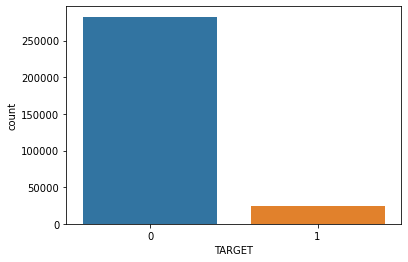

In [7]:
sns.countplot(x='TARGET',data=a_train)

In [8]:
prefix = 'EDA/a_test'

In [9]:
role = get_execution_role() 

data_key_test = 'a_test.csv' 
data_location_test = 's3://{}/{}/{}'.format(bucket, prefix, data_key_test) 

a_test = pd.read_csv(data_location_test) 
a_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100001,0,0,1,568800.0,450000.0,0.018850,-19241,-2329,-5170.0,...,0,0,0,0,0,1,0,0,1,0
1,100005,0,0,1,222768.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,0,1,1,663264.0,630000.0,0.019101,-20038,-4458,-2175.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,0,0,1,1575000.0,1575000.0,0.026392,-13976,-1866,-2000.0,...,0,0,0,1,0,1,0,0,1,0
4,100038,0,1,0,625500.0,625500.0,0.010032,-13040,-2191,-4000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0,0,1,412560.0,270000.0,0.002042,-19970,-5169,-9094.0,...,0,0,0,0,0,0,0,0,0,0
48740,456222,0,0,0,622413.0,495000.0,0.035792,-11186,-1149,-3015.0,...,0,0,0,0,0,0,0,0,0,0
48741,456223,0,1,1,315000.0,315000.0,0.026392,-15922,-3037,-2681.0,...,0,0,0,0,0,1,0,0,1,0
48742,456224,0,0,0,450000.0,450000.0,0.018850,-13968,-2731,-1461.0,...,0,0,0,0,0,1,0,0,1,0


In [10]:
a_test.shape

(48744, 154)

In [11]:
a_train.dtypes.value_counts()

int64      144
float64     11
dtype: int64

In [12]:
a_test.dtypes.value_counts()

int64      143
float64     11
dtype: int64

## Imputação de valores faltantes (células vazias)

In [13]:
def missing_val_ratio(a_train):
    perc_na = (a_train.isnull().sum()/len(a_train))*100
    ratio_na = perc_na.sort_values(ascending=False)
    missing_data_table = pd.DataFrame({'% of Total Values' :ratio_na})
    return missing_data_table

In [14]:
a_train_miss = missing_val_ratio(a_train)
a_train_miss.head(20)

,% of Total Values
OWN_CAR_AGE,65.990810
EXT_SOURCE_1,56.381073
APARTMENTS_AVG,50.749729
TOTALAREA_MODE,48.268517
EXT_SOURCE_3,19.825307
EXT_SOURCE_2,0.214626
AMT_GOODS_PRICE,0.090403
DAYS_LAST_PHONE_CHANGE,0.000325
ORGANIZATION_TYPE_Industry: type 2,0.000000
ORGANIZATION_TYPE_Industry: type 10,0.000000


In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range = (0, 1)) 

In [16]:
for column in a_train.columns:
    a_train[[column]] = imputer.fit_transform(a_train[[column]])
    a_train[[column]] = scaler.fit_transform(a_train[[column]])

In [17]:
a_train_miss = missing_val_ratio(a_train)
a_train_miss.head(25)

,% of Total Values
SK_ID_CURR,0.0
ORGANIZATION_TYPE_Industry: type 2,0.0
ORGANIZATION_TYPE_Hotel,0.0
ORGANIZATION_TYPE_Housing,0.0
ORGANIZATION_TYPE_Industry: type 1,0.0
ORGANIZATION_TYPE_Industry: type 10,0.0
ORGANIZATION_TYPE_Industry: type 11,0.0
ORGANIZATION_TYPE_Industry: type 12,0.0
ORGANIZATION_TYPE_Industry: type 13,0.0
ORGANIZATION_TYPE_Industry: type 3,0.0


In [18]:
a_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,0.000000,0.0,0.0,1.0,0.090287,0.077441,0.256321,0.111161,0.045086,0.852140,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.000003,0.0,0.0,0.0,0.311736,0.271605,0.045016,0.522886,0.043648,0.951929,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.000006,1.0,1.0,1.0,0.022472,0.023569,0.134897,0.651466,0.046161,0.827335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000011,0.0,0.0,1.0,0.066837,0.063973,0.107023,0.649154,0.038817,0.601451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000014,0.0,0.0,1.0,0.116854,0.117845,0.392880,0.701409,0.038820,0.825268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.999989,0.0,0.0,0.0,0.052360,0.046016,0.446855,0.103608,0.046133,0.657263,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
307507,0.999992,0.0,0.0,1.0,0.056067,0.046016,0.344429,0.748929,1.000000,0.822147,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
307508,0.999994,0.0,0.0,1.0,0.157969,0.135802,0.065247,0.421477,0.026076,0.726937,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
307509,0.999997,0.0,0.0,1.0,0.081175,0.069585,0.069553,0.252086,0.034258,0.896158,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [19]:
a_test_miss = missing_val_ratio(a_test)
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range = (0, 1))
for column in a_test.columns:
    a_test[[column]] = imputer.fit_transform(a_test[[column]])
    a_test[[column]] = scaler.fit_transform(a_test[[column]])
a_test_miss = missing_val_ratio(a_test)
a_test_miss.head(25)

,% of Total Values
SK_ID_CURR,0.0
ORGANIZATION_TYPE_Industry: type 13,0.0
ORGANIZATION_TYPE_Government,0.0
ORGANIZATION_TYPE_Hotel,0.0
ORGANIZATION_TYPE_Housing,0.0
ORGANIZATION_TYPE_Industry: type 1,0.0
ORGANIZATION_TYPE_Industry: type 10,0.0
ORGANIZATION_TYPE_Industry: type 11,0.0
ORGANIZATION_TYPE_Industry: type 12,0.0
ORGANIZATION_TYPE_Industry: type 2,0.0


In [20]:
a_train.shape

(307511, 155)

In [21]:
a_train.dtypes.value_counts()

float64    155
dtype: int64

In [22]:
a_test.shape

(48744, 154)

In [23]:
a_test.dtypes.value_counts()

float64    154
dtype: int64

## Ajustando o dataframe para dar início à criação dos modelos

In [24]:
first_column = a_train.pop('TARGET')
a_train.insert(0, 'TARGET', first_column)

In [25]:
a_train

,TARGET,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1.0,0.000000,0.0,0.0,1.0,0.090287,0.077441,0.256321,0.111161,0.045086,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.000003,0.0,0.0,0.0,0.311736,0.271605,0.045016,0.522886,0.043648,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.000006,1.0,1.0,1.0,0.022472,0.023569,0.134897,0.651466,0.046161,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000011,0.0,0.0,1.0,0.066837,0.063973,0.107023,0.649154,0.038817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000014,0.0,0.0,1.0,0.116854,0.117845,0.392880,0.701409,0.038820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.0,0.999989,0.0,0.0,0.0,0.052360,0.046016,0.446855,0.103608,0.046133,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
307507,0.0,0.999992,0.0,0.0,1.0,0.056067,0.046016,0.344429,0.748929,1.000000,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
307508,0.0,0.999994,0.0,0.0,1.0,0.157969,0.135802,0.065247,0.421477,0.026076,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
307509,1.0,0.999997,0.0,0.0,1.0,0.081175,0.069585,0.069553,0.252086,0.034258,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Modelling

## XGBoost (Modelo 01)

In [26]:
from sklearn.model_selection import train_test_split
train, test_and_validate = train_test_split(a_train, test_size = 0.2, random_state = 42, stratify = a_train['TARGET'])

In [27]:
test, validate = train_test_split(test_and_validate, test_size = 0.5, random_state = 42, stratify = test_and_validate['TARGET'])

In [28]:
print(train.shape)
print(test.shape)
print(validate.shape)

(246008, 155)
(30751, 155)
(30752, 155)


In [29]:
print(train['TARGET'].value_counts())
print(test['TARGET'].value_counts())
print(validate['TARGET'].value_counts())

0.0    226148
1.0     19860
Name: TARGET, dtype: int64
0.0    28269
1.0     2482
Name: TARGET, dtype: int64
0.0    28269
1.0     2483
Name: TARGET, dtype: int64


Uploading the data to Amazon S3

In [30]:
bucket = 'credit2022results'

In [31]:
prefix = 'XGBoost_02'

In [32]:
train_file='part_train.csv'
test_file='part_test.csv'
validate_file='part_validate.csv'

In [33]:
s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [34]:
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

In [35]:
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

In [36]:
hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

In [37]:
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

In [38]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

In [39]:
validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

In [40]:
data_channels = {'train': train_channel, 'validation': validate_channel}


In [41]:
xgb_model.fit(inputs=data_channels, logs=False)


2022-11-20 15:29:33 Starting - Starting the training job.....
2022-11-20 15:29:59 Starting - Preparing the instances for training..............
2022-11-20 15:31:18 Downloading - Downloading input data.......
2022-11-20 15:31:58 Training - Downloading the training image.........
2022-11-20 15:32:47 Training - Training image download completed. Training in progress..........
2022-11-20 15:33:38 Uploading - Uploading generated training model.
2022-11-20 15:33:49 Completed - Training job completed


In [42]:
batch_X = test.iloc[:,1:];

In [43]:
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [44]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

In [45]:
xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

In [46]:
xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')

..................................[2022-11-20:15:39:24:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-20:15:39:24:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-20:15:39:24:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2022-11-20 15:39:24 +0000] [18] [INFO] Starting g

In [47]:
xgb_transformer.wait()

[2022-11-20:15:39:24:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-20:15:39:24:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-20:15:39:24:INFO] nginx config: 
worker_processes auto;
daemon off;
[2022-11-20:15:39:24:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-20:15:39:24:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-20:15:39:24:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      p

In [48]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])

In [49]:
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

In [50]:
target_predicted_binary = target_predicted['class'].apply(binary_convert)

In [51]:
print(target_predicted_binary.head(5))
test.head(5)

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64


,TARGET,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
133535,0.0,0.434725,0.0,0.0,1.0,0.067582,0.062851,1.000000,0.366234,0.034837,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
158392,0.0,0.515417,0.0,1.0,0.0,0.262200,0.248036,0.134897,0.423901,0.037176,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6922,0.0,0.022630,1.0,1.0,1.0,0.073034,0.074074,0.129705,0.232018,0.045598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63020,0.0,0.205174,0.0,0.0,0.0,0.509393,0.438833,1.000000,0.413191,0.046214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
84644,0.0,0.275650,0.0,0.0,1.0,0.318170,0.277217,0.090864,0.510936,0.025830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Criando de uma matriz de confusão (confusion matrix)

In [52]:
test_labels = test.iloc[:,0]
test_labels.head()

133535    0.0
158392    0.0
6922      0.0
63020     0.0
84644     0.0
Name: TARGET, dtype: float64

In [53]:
from sklearn.metrics import confusion_matrix

In [54]:
matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Reembolsa','Não reembolsa'],columns=['Reembolsa','Não reembolsa'])

In [55]:
df_confusion

,Reembolsa,Não reembolsa
Reembolsa,27743,526
Não reembolsa,2156,326


In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

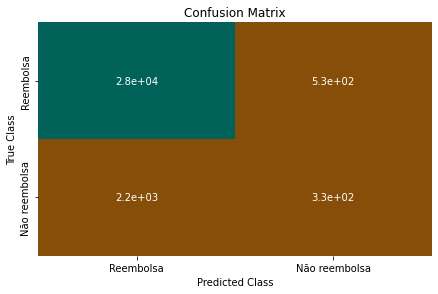

In [57]:
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

## Cálculo dos dados estatísticos de desempenho

In [58]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [59]:
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

In [60]:
print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 27743
False Positive (FP): 526
False Negative (FN): 2156
True Positive (TP) : 326


In [61]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {Sensitivity}% chance of detecting patients with an abnormality have an abnormality")

Sensitivity or TPR: 13.13456889605157%
There is a 13.13456889605157% chance of detecting patients with an abnormality have an abnormality


In [62]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of detecting normal patients are normal.")

Specificity or TNR: 98.13930453854044%
There is a 98.13930453854044% chance of detecting normal patients are normal.


In [63]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You have an abnormality, and the probablity that is correct is {Precision}%")

Precision: 38.26291079812207%
You have an abnormality, and the probablity that is correct is 38.26291079812207%


In [64]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )

Negative Predictive Value: 92.78905649018363%
You don't have an abnormality, but there is a 92.78905649018363% chance that is incorrect


In [65]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")

False Positive Rate: 1.8606954614595494%
There is a 1.8606954614595494% chance that this positive result is incorrect.


In [66]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 86.86543110394844%
There is a 86.86543110394844% chance that this negative result is incorrect.


In [67]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 61.737089201877936%
You have an abnormality, but there is a 61.737089201877936% chance this is incorrect.


In [68]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 91.27833241195408%


In [69]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%")

Sensitivity or TPR: 13.13456889605157%
Specificity or TNR: 98.13930453854044%
Precision: 38.26291079812207%
Negative Predictive Value: 92.78905649018363%
False Positive Rate: 1.8606954614595494%
False Negative Rate: 86.86543110394844%
False Discovery Rate: 61.737089201877936%
Accuracy: 91.27833241195408%


## Cálculo do AUC-ROC

In [70]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted) )

Validation AUC 0.7500147369739474


In [71]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
roc_auc = auc(fpr, tpr)

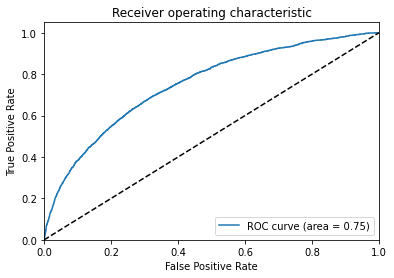

In [72]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

(0.0, 1.0)

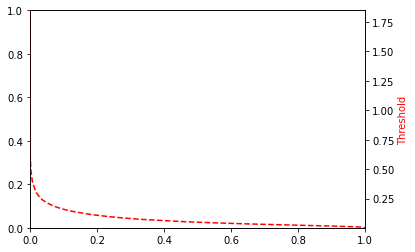

In [73]:
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

In [74]:
print(plt.figure())

Figure(432x288)


<Figure size 432x288 with 0 Axes>

## Regressão Logistica

In [75]:
y = a_train['TARGET']
X = a_train.drop(labels=['TARGET'],axis=1)

In [76]:
#prediction is on y_train
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=.30,random_state=1)

In [77]:
from sklearn.linear_model import LogisticRegression
print(X_train.shape)
print(X_valid.shape)

(215257, 154)
(92254, 154)


In [78]:

# TREINAMENTO
clf_logistic = LogisticRegression(solver='lbfgs')
clf_logistic_fit = clf_logistic.fit(X_train,y_train)
#clf_logistic_fit.coef_

In [79]:
probs=pd.DataFrame(clf_logistic.predict_proba(X_valid)).head()
probs

,0,1
0,0.963493,0.036507
1,0.917126,0.082874
2,0.966487,0.033513
3,0.921054,0.078946
4,0.453081,0.546919


In [80]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,recall_score,accuracy_score,precision_score
from sklearn.model_selection import train_test_split

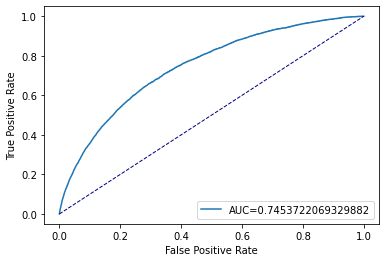

In [81]:
#VALIDAÇÃO
y_pred = clf_logistic_fit.predict(X_valid)
y_pred_proba = clf_logistic_fit.predict_proba(X_valid)[::,1]
fpr, tpr, _ = metrics.roc_curve( y_valid,  y_pred_proba)
auc = metrics.roc_auc_score( y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [82]:
print (classification_report(y_true=y_valid,
                            y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84787
         1.0       0.48      0.01      0.02      7467

    accuracy                           0.92     92254
   macro avg       0.70      0.50      0.49     92254
weighted avg       0.88      0.92      0.88     92254



In [83]:
acc1=accuracy_score(y_true=y_valid,
               y_pred=y_pred)
print('Logistic regression accuracy_score',acc1)

Logistic regression accuracy_score 0.9189845426756563


In [84]:
matrix = confusion_matrix(y_valid, y_pred)
matrix

array([[84710,    77],
       [ 7397,    70]])

## Deployment

Aqui fazemos o deploy do modelo para um ponto final hospedado

In [ ]:
xgb_predictor = target_predicted_binary.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

## Configuração do EndPpoint

O SageMaker suporta a configuração de pontos finais dos modelos hospedados. Os clientes criam uma configuração de endpoint, que descreve a distribuição do tráfego através dos modelos, seja dividido, sombreado ou amostrado de alguma forma. Além disso, a configuração do ponto final descreve o tipo de instância necessária para a implantação do modelo

In [ ]:
from time import gmtime, strftime

endpoint_config_name = f"DEMO-XGBoostEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
print(f"Creating endpoint config with name: {endpoint_config_name}.")
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": xgb_model,
            "VariantName": "AllTraffic",
        }
    ],
)

print(f"Endpoint Config Arn: {create_endpoint_config_response['EndpointConfigArn']}")

## Criando o Endpoint

É criado um endpoint na mesma instacia em que esta o container do XGBoost, o endpoint tem a finalidade de evitar custos desnecessarios com uma instancia após conclusão de uma modelagem.

In [ ]:
%%time
import time

endpoint_name = f'DEMO-XGBoostEndpoint-{strftime("%Y-%m-%d-%H-%M-%S", gmtime())}'
print(f"Creating endpoint with name: {endpoint_name}. This will take between 9 and 11 minutes to complete.")
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
while status == "Creating":
    print(f"Status: {status}")
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]

print(f"Arn: {resp['EndpointArn']}")
print(f"Status: {status}")

## Deleta o endpoit

Esta etapa faz a limpeza do endpoint criado na instacia do S3. 

In [ ]:
xgb_transformer.delete_endpoint(EndpointName=xgb_predictor)

## Randon Forest

In [85]:
y = a_train['TARGET']
X = a_train.drop(labels=['TARGET'],axis=1)

In [86]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=.30,random_state=1)

In [87]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

In [88]:
#X=X_train
#y=y_train
#X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=.30,random_state=1)

# TREINAMENTO
param_grid={'max_depth':range(1,20,2)}
forest = RandomForestClassifier()
random_forest = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy',n_jobs=-1).fit(X_train,y_train)

# VALIDAÇÃO
y_pred = random_forest.predict(X_valid)
print(classification_report(y_true=y_valid, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84787
         1.0       1.00      0.00      0.00      7467

    accuracy                           0.92     92254
   macro avg       0.96      0.50      0.48     92254
weighted avg       0.93      0.92      0.88     92254



In [89]:
print(accuracy_score(y_valid,y_pred))

0.9190712597827736


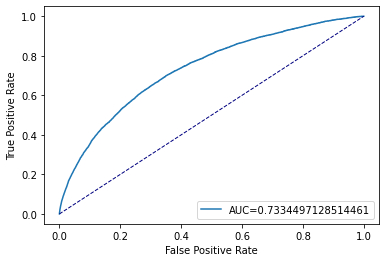

In [90]:
y_pred_proba = random_forest.predict_proba(X_valid)[::,1]
fpr, tpr, _ = metrics.roc_curve( y_valid,  y_pred_proba)
auc = metrics.roc_auc_score( y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Comparação entre os 3 métodos de ML

Text(0, 0.5, 'Auc')

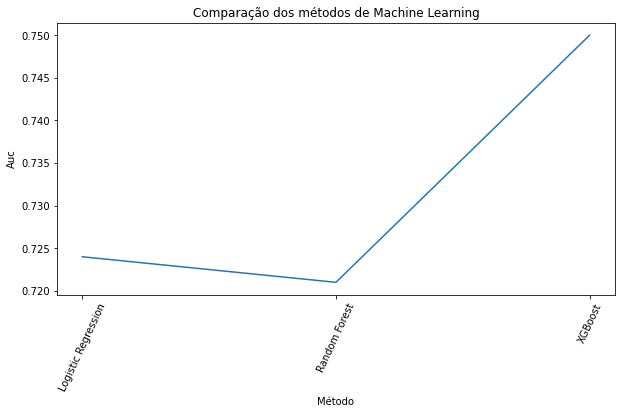

In [91]:
name = ['Logistic Regression','Random Forest','XGBoost']
auc = [0.745,0.733,0.75]
plt.figure(figsize=(10,5))
sns.lineplot(x=name,y=auc)
plt.xticks(rotation=65)
plt.title('Comparação dos métodos de Machine Learning')
plt.xlabel('Método')
plt.ylabel('Auc')

Este gráfico mostra que o XGBoost teve um desepenho melhor que os outros dois modelos

## Teste

## Regressão Logistica
O treinamento de Regressão logistica alpicado no csv de teste predizeu apenas 0,2% de clientes potenciais inadimplentes. 

In [92]:
y_pred_LOGISTIC = clf_logistic_fit.predict(a_test)
print((y_pred_LOGISTIC == 0).sum())
print((y_pred_LOGISTIC == 1).sum())

48655
89


## Random Forest
O treinamento de Random Forest aplicado no csv de teste não detectou potenciais clientes inadimplentes.

In [93]:
y_pred_FOREST = random_forest.predict(a_test)
print((y_pred_FOREST == 0).sum())
print((y_pred_FOREST == 1).sum())

48744
0


In [94]:
a_test['TARGET_L'] = y_pred_LOGISTIC
a_test['TARGET_F'] = y_pred_FOREST
a_test.to_csv('a_test_with_targets.csv')

O resultado do Random forest mostra o quão problematico é o desbalanceamento do dataframe. O modelo não encontrou nenhum caso de potencial cliente devedor, isto para uma empresa representa um alto risco de crédito a perfis que o modelo não conseguiu identificar. Esta conclusão só se deve pq é esperado que ao menos 8% do dataset sejam possiveis inadimplentes (seguindo a lógica que a tendencia de um grupo inadimplente siga por voltados 8% do dataset de treino). 
Logo fica claro que é necessário balancear o data frame e fazer novos treinamentos. 